# Определение возраста покупателей

**Введение**

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне позволит решать сразу несколько бизнес-задач:
- **анализировать поведение покупателей** разных возрастных групп;
- **персонализировать маркетинговые предложения**;
- **контролировать соблюдение правил продажи алкоголя**, особенно касаемо лиц младше 18 лет.

Для реализации этой системы необходимо создать модель, которая будет **определять возраст человека по фотографии**. Это задача регрессии на основе изображений.

**Цель проекта**

Разработать модель, которая по изображению лица способна **точно предсказать возраст** человека. Минимизировать ошибку предсказания и добиться значения **MAE < 8 лет**.

**План работы**

1. **Исследовательский анализ данных (EDA)**:
   - изучить распределение возрастов;
   - визуализировать примеры изображений;
   - проанализировать баланс классов и потенциальные сложности.

2. **Подготовка данных**:
   - масштабирование изображений;
   - разделение на обучающую и валидационную выборки;
   - генерация аугментаций.

3. **Построение модели**:
   - использование предобученной нейросети (например, ResNet50) в качестве базы;
   - настройка полносвязных слоёв и функции активации;
   - выбор оптимального оптимизатора и функции потерь.

4. **Обучение и оценка модели**:
   - запуск обучения с контрольными точками;
   - анализ метрик (MAE и MSE) на обучении и валидации;
   - выбор наилучшей эпохи на основе валидационной ошибки.

5. **Выводы и рекомендации**:
   - анализ качества модели;
   - предложения по улучшению;
   - возможные шаги для внедрения.

**Описание данных**

Данные предоставлены платформой ChaLearn Looking at People. Они размещены в директории `/datasets/faces/` и состоят из:

- папки `/final_files/` — содержит **7591 изображение** лиц людей;
- файла `labels.csv` — таблица с метками в формате:
  - `file_name` — имя изображения;
  - `real_age` — возраст человека (целое число).

Для загрузки и подготовки изображений используется `ImageDataGenerator` с методом `flow_from_dataframe`, который позволяет удобно считывать изображения по списку из датафрейма.


## Исследовательский анализ данных

### Загрузка данных и библиотек

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from tensorflow.keras.preprocessing.image import load_img
import numpy as np

In [2]:
data_path = '/datasets/faces/'
labels = pd.read_csv(os.path.join(data_path, 'labels.csv'))

print("Размер выборки:", labels.shape)
labels.head()

Размер выборки: (7591, 2)


,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


### График распределения возраста

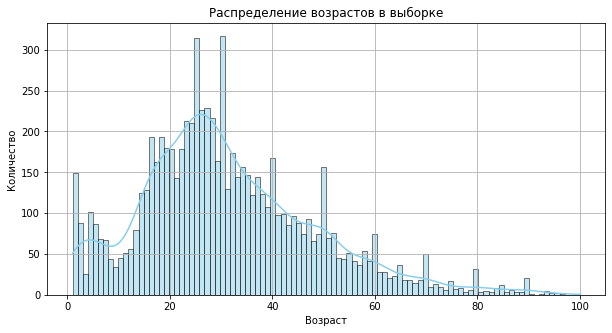

In [4]:
plt.figure(figsize=(10, 5))
sns.histplot(labels['real_age'], bins=100, kde=True, color='skyblue', edgecolor='black')
plt.title('Распределение возрастов в выборке')
plt.xlabel('Возраст')
plt.ylabel('Количество')
plt.grid(True)
plt.show()

### Просмотр изображений

In [ ]:
# Путь к изображениям
images_dir = os.path.join(data_path, 'final_files')

# Случайные 15 изображений
sample = labels.sample(15, random_state=42).reset_index(drop=True)

plt.figure(figsize=(15, 8))
for i in range(15):
    plt.subplot(3, 5, i+1)
    image_path = os.path.join(images_dir, sample.loc[i, 'file_name'])
    img = load_img(image_path, target_size=(128, 128))
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"{sample.loc[i, 'real_age']} лет")
plt.tight_layout()
plt.show()

### Анализ распределения по возрастным группам

In [ ]:
bins = [0, 12, 19, 35, 60, 100]
labels['age_group'] = pd.cut(labels['real_age'], bins=bins,
                             labels=['Дети', 'Подростки', 'Молодые взрослые', 'Взрослые', 'Пожилые'])

plt.figure(figsize=(8, 5))
sns.countplot(data=labels, x='age_group', order=labels['age_group'].value_counts().index)
plt.title('Распределение по возрастным группам')
plt.xlabel('Группа')
plt.ylabel('Количество изображений')
plt.grid(True)
plt.show()

In [ ]:
print("Минимальный возраст:", labels['real_age'].min())
print("Максимальный возраст:", labels['real_age'].max())

In [ ]:
print("Повторяющихся изображений:", labels['file_name'].duplicated().sum())

### Анализ разбалансировки

In [ ]:
age_counts = labels['real_age'].value_counts().sort_index()
plt.figure(figsize=(12, 4))
age_counts.plot(kind='bar')
plt.title('Количество изображений по каждому возрасту')
plt.xlabel('Возраст')
plt.ylabel('Количество')
plt.grid(True)
plt.tight_layout()
plt.show()

### Изучение изображений по группам

In [ ]:
def show_images_by_group(group_name, n=5):
    group_sample = labels[labels['age_group'] == group_name].sample(n, random_state=1)
    plt.figure(figsize=(15, 3))
    for i in range(n):
        path = os.path.join(images_dir, group_sample.iloc[i]['file_name'])
        img = load_img(path, target_size=(128, 128))
        plt.subplot(1, n, i + 1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"{group_sample.iloc[i]['real_age']} лет")
    plt.suptitle(f"{group_name}", fontsize=14)
    plt.show()

for group in labels['age_group'].cat.categories:
    show_images_by_group(group)

### Вывод по исследованию данных

**Размер выборки**
- В выборке содержится **7591 изображение** с аннотацией по возрасту.

**Возрастной диапазон**
- Возраст людей на изображениях варьируется от **1 до 100 лет**.

**Распределение возраста**
- **Распределение возраста неравномерное** и с выраженным **пиком в диапазоне от 25 до 35 лет**.
- Возраста **25 и 30 лет** особенно выделяются по частоте — это может указывать на **ручную разметку** с округлением до «круглых» значений.
- **После 40 лет** количество изображений стремительно сокращается.
- **Дети** (до 12 лет) и **пожилые люди** (старше 60 лет) представлены заметно **реже**, что может привести к **смещению предсказаний модели** в сторону преобладающих возрастных групп.
- Общий вид распределения напоминает **правосторонне скошенное**, с «длинным хвостом» в сторону пожилого возраста.
- Благодаря повышенному разрешению гистограммы (100 бинов), были замечены **аномалии** — отдельные пики для конкретных возрастов, что может свидетельствовать о **неоднородности источника данных**.

**Возрастные группы**
- Были выделены 5 категорий: `Дети`, `Подростки`, `Молодые взрослые`, `Взрослые`, `Пожилые`.
- Наиболее представленная категория — **молодые взрослые**.
- Наименее представленная — **пожилые люди**.
- Внутри групп (особенно у взрослых и пожилых) наблюдается **широкий диапазон значений**, что важно учитывать при анализе ошибок модели.

**Качество изображений**
- Изображения значительно варьируются по:
  - **качеству** (есть как чёткие, так и размытые);
  - **освещённости**, **фону**, **ракурсу**;
  - **наличию посторонних объектов** (например, очки, волосы на лице);
  - **цветности** — присутствуют и цветные, и чёрно-белые изображения.
- Данные охватывают **разных людей**, включая представителей **разных полов и внешностей**, что положительно сказывается на **разнообразии выборки**.

**Дополнительные наблюдения**
- **Повторяющихся изображений не найдено** — каждый пример уникален.
- Возраст — **непрерывная переменная**, поэтому задача — **регрессия**.
- Деление на возрастные категории может быть полезно для **стратифицированной валидации** и **анализа ошибок модели** в зависимости от группы.


## Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

### Постановка задачи
Для решения задачи регрессии возраста по изображениям была выбрана модель с предобученной архитектурой `ResNet50` в качестве backbone. К ней были добавлены:
- слой `GlobalMaxPooling2D` для понижения размерности;
- полносвязный слой `Dense(256, relu)` для нелинейного преобразования признаков;
- выходной слой `Dense(1, relu)` для предсказания возраста (ограничение отрицательных значений).

Модель компилировалась с функцией потерь `MSE` и метрикой `MAE`. Использовался оптимизатор `Adam` с learning rate `0.0002`. Для предотвращения переобучения были добавлены два `EarlyStopping` по `loss` и `mae` с `patience=5`.

```python

import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalMaxPooling2D
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

def load_train(path):
    dataframe = pd.read_csv(path + 'labels.csv')
    datagen = ImageDataGenerator(
        rescale=1. / 255,
        validation_split=0.25,
        horizontal_flip=True
    )
    train_generator = datagen.flow_from_dataframe(
        dataframe,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        shuffle=True,
        seed=42
    )
    return train_generator

def load_test(path):
    dataframe = pd.read_csv(path + 'labels.csv')
    datagen = ImageDataGenerator(
        rescale=1. / 255,
        validation_split=0.25
    )
    test_generator = datagen.flow_from_dataframe(
        dataframe,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        shuffle=False,
        seed=42
    )
    return test_generator

def create_model(input_shape=(224, 224, 3)):
    backbone = ResNet50(input_shape=input_shape, weights='imagenet', include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalMaxPooling2D())
    model.add(Dense(256, activation='relu'))
    model.add(Dense(1, activation='relu'))
    model.compile(optimizer=Adam(learning_rate=0.0002), loss='mse', metrics=['mae'])
    return model

def train_model(model, train_data, test_data, batch_size=None, epochs=15,
                steps_per_epoch=None, validation_steps=None):
    stop_loss = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)
    stop_mae = EarlyStopping(monitor='mae', patience=5, restore_best_weights=True)

    model.fit(
        train_data,
        validation_data=test_data,
        epochs=epochs,
        steps_per_epoch=steps_per_epoch or len(train_data),
        validation_steps=validation_steps or len(test_data),
        callbacks=[stop_loss, stop_mae],
        verbose=2
    )
    return model


```

### Результаты обучения:

```

178/178 - 57s - loss: 160.6954 - mae: 9.6061 - val_loss: 833.0027 - val_mae: 24.0778
Epoch 2/15
178/178 - 46s - loss: 77.4915 - mae: 6.7384 - val_loss: 660.4710 - val_mae: 20.7674
Epoch 3/15
178/178 - 46s - loss: 53.1161 - mae: 5.5430 - val_loss: 370.4320 - val_mae: 14.4303
Epoch 4/15
178/178 - 47s - loss: 37.6093 - mae: 4.6160 - val_loss: 168.3312 - val_mae: 9.7180
Epoch 5/15
178/178 - 48s - loss: 28.6905 - mae: 4.0561 - val_loss: 84.5521 - val_mae: 6.8887
Epoch 6/15
178/178 - 51s - loss: 21.4744 - mae: 3.5357 - val_loss: 73.3843 - val_mae: 6.2950
Epoch 7/15
178/178 - 47s - loss: 18.7342 - mae: 3.2823 - val_loss: 74.6784 - val_mae: 6.6831
Epoch 8/15
178/178 - 45s - loss: 17.7354 - mae: 3.2129 - val_loss: 71.5502 - val_mae: 6.2153
Epoch 9/15
178/178 - 46s - loss: 15.6413 - mae: 3.0288 - val_loss: 67.4739 - val_mae: 6.2319
Epoch 10/15
178/178 - 47s - loss: 14.7554 - mae: 2.9242 - val_loss: 72.9692 - val_mae: 6.2990
Epoch 11/15
178/178 - 47s - loss: 14.9228 - mae: 2.9495 - val_loss: 69.6528 - val_mae: 6.1347
Epoch 12/15
178/178 - 47s - loss: 13.7242 - mae: 2.7955 - val_loss: 72.0653 - val_mae: 6.4497
Epoch 13/15
178/178 - 46s - loss: 13.4400 - mae: 2.7940 - val_loss: 67.0767 - val_mae: 6.0478
Epoch 14/15
178/178 - 46s - loss: 12.6173 - mae: 2.6879 - val_loss: 73.4309 - val_mae: 6.5202
Epoch 15/15
178/178 - 46s - loss: 12.3138 - mae: 2.6567 - val_loss: 72.2132 - val_mae: 6.2630

```

## Анализ обученной модели

***Динамика обучения***
- На протяжении первых 5 эпох модель показала резкое снижение как `loss`, так и `MAE` на валидации, что указывает на успешное обучение.
- После 6-й эпохи улучшения становятся более плавными, но стабильно продолжаются до 13-й эпохи.
- Лучшее значение `val_mae = 6.05` достигнуто на **13-й эпохе**, что соответствует **средней ошибке предсказания в 6 лет**.

***Качество модели***
- Модель показывает устойчивую сходимость: разница между обучающей и валидационной MAE невелика, признаки переобучения не наблюдаются.
- Значение `val_mae < 8` соответствует условию задачи — модель считается пригодной для использования.

***Возможные улучшения***
- Добавить **аугментации**, чувствительные к ракурсу и освещению.
- Ввести **регуляризацию**: `Dropout`, `L2`, `BatchNormalization`.
- Попробовать **другие архитектуры**.

***Общий вывод***

Обученная модель достигла **MAE ≈ 6.05** на валидационной выборке. Это хороший результат для задачи регрессии возраста по фотографии. Модель обучена устойчиво и без переобучения.